# NISQA_TRAIN_SIM Dataset Demo

This notebook provides an exploratory data analysis (EDA) and audio demonstration of the **NISQA_TRAIN_SIM** dataset.

## Dataset Overview
Based on the provided readme, this dataset contains simulated distortions applied to speech files. It is used to train models for multidimensional speech quality prediction.

- **Files:** 10,000 training files
- **Distortions:** AWGN, MNRU, DNS-Challenge Noise, Filters, Clipping, Codecs (AMR, EVS, Opus, etc.), and Packet Loss.
- **Targets:** 
    - `mos`: Overall Mean Opinion Score
    - `noi`: Noisiness
    - `col`: Coloration
    - `dis`: Discontinuity
    - `loud`: Loudness

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Configuration and Data Loading

We will load the main metadata file: `NISQA_TRAIN_SIM_file.csv`.

In [10]:
# Define paths based on directory structure - robust search
possible_paths = [
    Path("data/raw/NISQA_Corpus/NISQA_TRAIN_SIM"),
    Path("../data/raw/NISQA_Corpus/NISQA_TRAIN_SIM"),
    Path("../../data/raw/NISQA_Corpus/NISQA_TRAIN_SIM")
]

BASE_DIR = None
for p in possible_paths:
    if (p / "NISQA_TRAIN_SIM_file.csv").exists():
        BASE_DIR = p
        break

if BASE_DIR is None:
    print(f"Error: Could not find dataset directory. Current CWD: {Path().resolve()}")
    CSV_PATH = Path("data/raw/NISQA_Corpus/NISQA_TRAIN_SIM/NISQA_TRAIN_SIM_file.csv") # fallback
else:
    CSV_PATH = BASE_DIR / "NISQA_TRAIN_SIM_file.csv"
    print(f"Found dataset at: {BASE_DIR.resolve()}")

# Check if file exists
if not CSV_PATH.exists():
    print(f"Error: CSV not found at {CSV_PATH}. Please check the path.")
else:
    # Load the dataframe
    df = pd.read_csv(CSV_PATH)
    print(f"Dataset loaded successfully with {len(df)} rows and {len(df.columns)} columns.")

Found dataset at: /Users/davidlindahl/Documents/DTU/Bachelor/automatic-speech-assessment/data/raw/NISQA_Corpus/NISQA_TRAIN_SIM
Dataset loaded successfully with 10000 rows and 52 columns.


## 2. Data Inspection
Let's look at the available columns and the first few rows. The dataset contains both metadata (distortion parameters) and target labels (MOS scores).

In [11]:
pd.set_option('display.max_columns', None)
display(df.head())

,db,con,file,con_description,filename_deg,filename_ref,source,lang,votes,mos,noi,col,dis,loud,noi_std,col_std,dis_std,loud_std,mos_std,filepath_deg,filepath_ref,filter,timeclipping,wbgn,p50mnru,bgn,clipping,arb_filter,asl_in,asl_out,codec1,codec2,codec3,plcMode1,plcMode2,plcMode3,wbgn_snr,bgn_snr,tc_fer,tc_nburst,cl_th,bp_low,bp_high,p50_q,bMode1,bMode2,bMode3,FER1,FER2,FER3,asl_in_level,asl_out_level
0,NISQA_TRAIN_SIM,1.0,1,simulated,c00001_3_640_2_7_001-ch6-speaker_seg49.wav,3_640_2_7_001-ch6-speaker_seg49.wav,AusTalk,en,5.0,1.6,1.448340,3.800148,4.418986,3.046822,0.481258,1.017052,0.854869,1.181490,0.894427,NISQA_TRAIN_SIM/deg/c00001_3_640_2_7_001-ch6-s...,NISQA_TRAIN_SIM/ref/3_640_2_7_001-ch6-speaker_...,-,-,x,-,-,-,-,-,-,-,-,-,-,-,-,1.515152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NISQA_TRAIN_SIM,2.0,2,simulated,c00002_1_319_2_7_001-ch6-speaker_seg63.wav,1_319_2_7_001-ch6-speaker_seg63.wav,AusTalk,en,5.0,1.6,1.230793,3.436207,4.251038,2.572295,0.327156,1.588376,0.885480,1.566098,0.894427,NISQA_TRAIN_SIM/deg/c00002_1_319_2_7_001-ch6-s...,NISQA_TRAIN_SIM/ref/1_319_2_7_001-ch6-speaker_...,-,-,x,-,-,-,-,-,-,-,-,-,-,-,-,7.575758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NISQA_TRAIN_SIM,3.0,3,simulated,c00003_3_864_2_7_001-ch6-speaker_seg91.wav,3_864_2_7_001-ch6-speaker_seg91.wav,AusTalk,en,5.0,1.6,1.499323,3.532891,3.738763,3.175759,0.284915,1.401878,1.088683,1.531573,0.547723,NISQA_TRAIN_SIM/deg/c00003_3_864_2_7_001-ch6-s...,NISQA_TRAIN_SIM/ref/3_864_2_7_001-ch6-speaker_...,-,-,x,-,-,-,-,-,-,-,-,-,-,-,-,10.606061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NISQA_TRAIN_SIM,4.0,4,simulated,c00004_2_1011_2_7_001-ch6-speaker_seg41.wav,2_1011_2_7_001-ch6-speaker_seg41.wav,AusTalk,en,5.0,1.8,1.256343,3.773027,4.022083,2.608239,0.164578,1.517249,0.854899,1.719475,0.836660,NISQA_TRAIN_SIM/deg/c00004_2_1011_2_7_001-ch6-...,NISQA_TRAIN_SIM/ref/2_1011_2_7_001-ch6-speaker...,-,-,x,-,-,-,-,-,-,-,-,-,-,-,-,12.626263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NISQA_TRAIN_SIM,5.0,5,simulated,c00005_book_01337_chp_0002_reader_06379_5_seg.wav,book_01337_chp_0002_reader_06379_5_seg.wav,DNS,en,5.0,2.4,1.457287,4.355442,3.784883,4.648346,0.455895,0.536740,1.135078,0.307832,0.894427,NISQA_TRAIN_SIM/deg/c00005_book_01337_chp_0002...,NISQA_TRAIN_SIM/ref/book_01337_chp_0002_reader...,-,-,x,-,-,-,-,-,-,-,-,-,-,-,-,14.646465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Distribution of Target Scores (MOS)

The dataset provides an overall quality score (`mos`) and four dimension-specific scores. 
- `mos`: Mean Opinion Score (1-5)
- `noi`: Noisiness
- `col`: Coloration
- `dis`: Discontinuity
- `loud`: Loudness

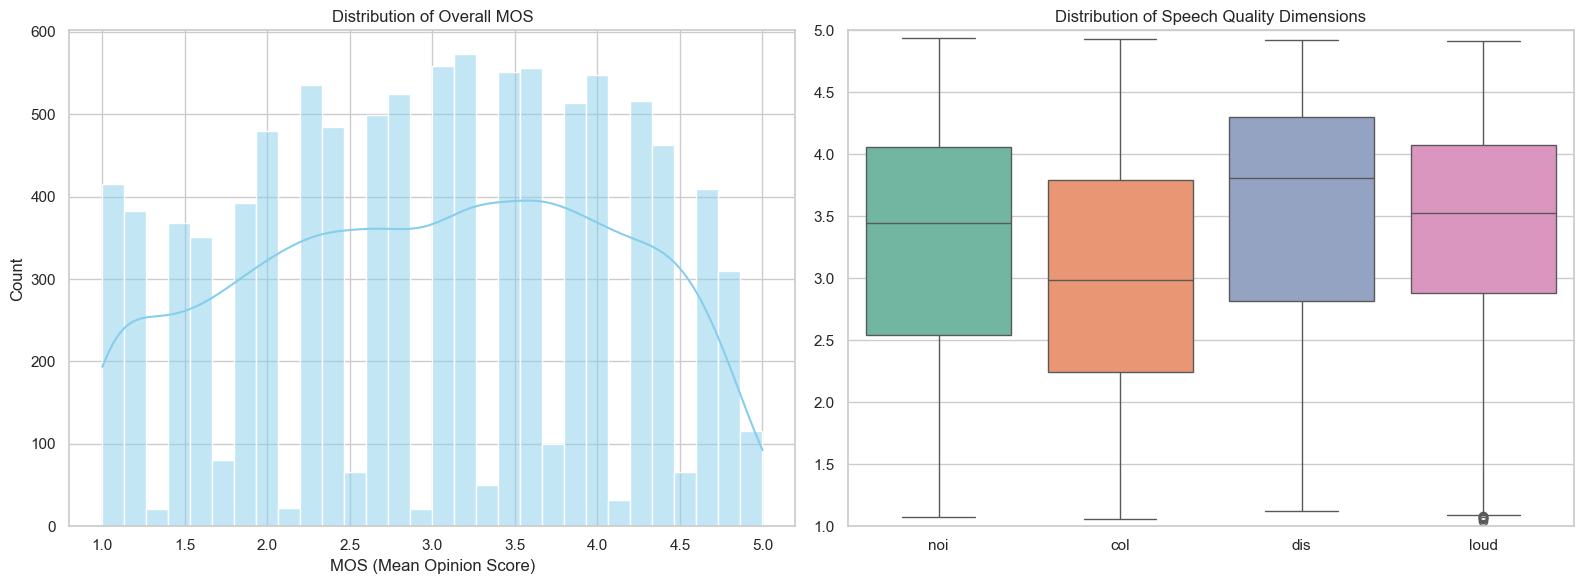

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall MOS Distribution
sns.histplot(df['mos'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Overall MOS')
axes[0].set_xlabel('MOS (Mean Opinion Score)')

# Plot 2: Dimensions Boxplot
dimensions = df[['noi', 'col', 'dis', 'loud']]
sns.boxplot(data=dimensions, ax=axes[1], palette="Set2")
axes[1].set_title('Distribution of Speech Quality Dimensions')
axes[1].set_ylim(1, 5)

plt.tight_layout()
plt.show()

## 4. Analyzing Distortion Effects

The dataset includes various simulated distortions. Let's analyze how specific parameters affect the MOS.

### 4.1 Impact of Codecs
We compare the MOS distribution across different primary codecs (`codec1`).

/var/folders/js/tk26df7j5qz2m906xlhckh5r0000gn/T/ipykernel_5182/1548543172.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='codec1', y='mos', data=df_codecs, palette='viridis')


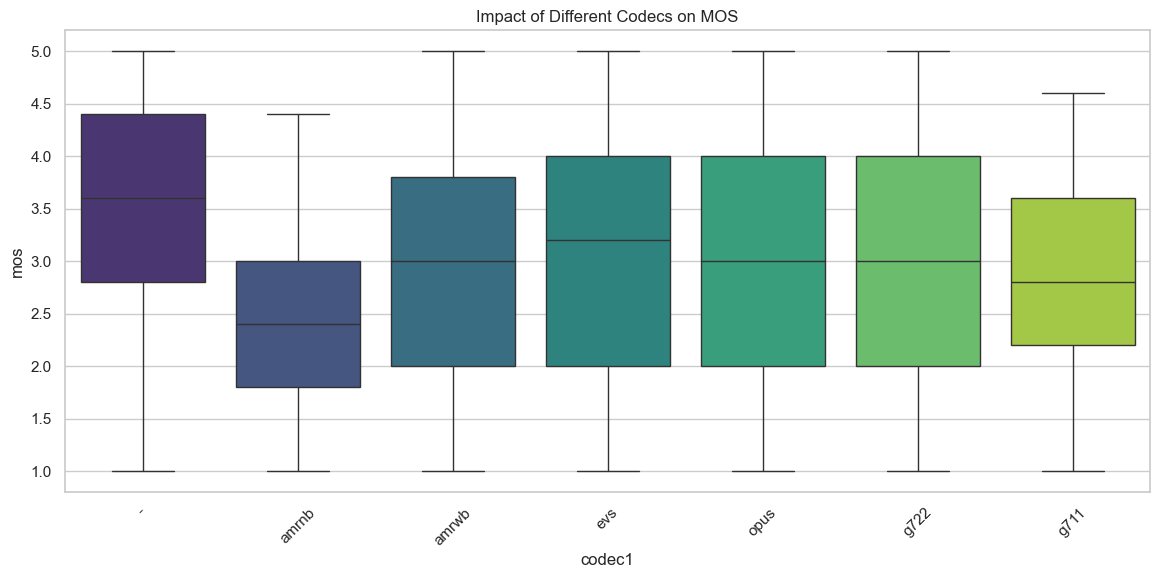

In [13]:
# Filter for rows where a codec was actually applied (codec1 is not NaN/Empty)
# Note: Adjust filtering based on actual empty values in your CSV (e.g., 'none', nan, or 0)
if 'codec1' in df.columns:
    plt.figure(figsize=(14, 6))
    
    # Get top codecs by frequency to avoid clutter
    top_codecs = df['codec1'].value_counts().index[:10]
    df_codecs = df[df['codec1'].isin(top_codecs)]
    
    sns.boxplot(x='codec1', y='mos', data=df_codecs, palette='viridis')
    plt.title('Impact of Different Codecs on MOS')
    plt.xticks(rotation=45)
    plt.show()

### 4.2 Impact of White Noise (SNR)
We look at the relationship between White Gaussian Noise SNR (`wbgn_snr`) and the Noisiness (`noi`) and Overall (`mos`) scores.

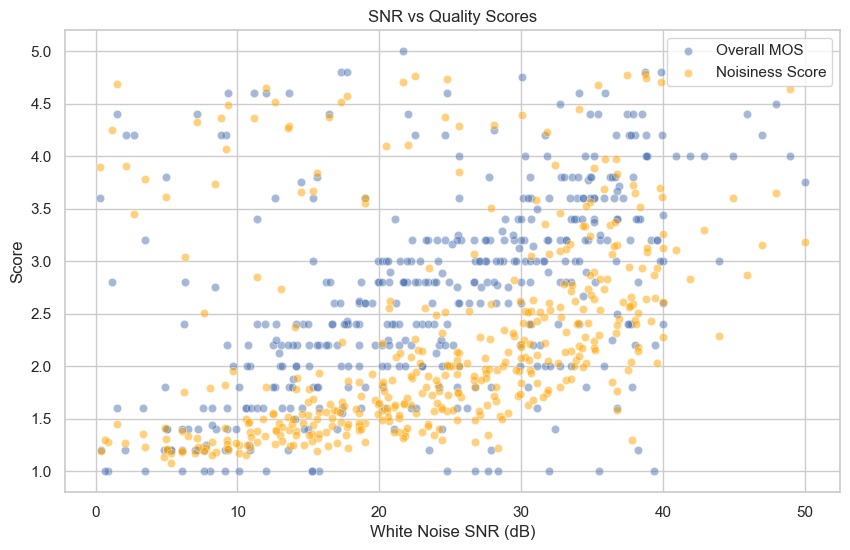

In [14]:
# Filter data where White Background Noise was applied (snr != 0 or valid)
if 'wbgn_snr' in df.columns:
    # Assuming 0 or very high number might mean 'no noise', checking distribution first
    # Let's plot only entries where noise is present
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='wbgn_snr', y='mos', data=df, alpha=0.5, label='Overall MOS')
    sns.scatterplot(x='wbgn_snr', y='noi', data=df, alpha=0.5, color='orange', label='Noisiness Score')
    
    plt.title('SNR vs Quality Scores')
    plt.xlabel('White Noise SNR (dB)')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

## 5. Audio Playback Demo

Compare the **Reference** (Clean) audio with the **Degraded** (Simulated) audio side-by-side.

**Note:** This requires the audio files to be present in the `deg/` and `ref/` subfolders.

In [15]:
def listen_to_sample(row_index=None):
    """
    Selects a sample and displays audio players for Ref and Deg files.
    """
    if row_index is None:
        sample = df.sample(1).iloc[0]
    else:
        sample = df.iloc[row_index]
        
    # Construct full paths
    # The CSV columns 'filepath_deg' and 'filepath_ref' include the dataset folder name (NISQA_TRAIN_SIM/...). 
    # So we join them with the parent of BASE_DIR to avoid duplication: data/raw/NISQA_Corpus + NISQA_TRAIN_SIM/...
    
    path_deg = BASE_DIR.parent / str(sample['filepath_deg'])
    path_ref = BASE_DIR.parent / str(sample['filepath_ref'])

    print(f"--- File Info ---")
    print(f"File Name: {sample['file']}")
    print(f"Condition: {sample['con_description']}")
    print(f"MOS: {sample['mos']:.2f} | Noi: {sample['noi']:.2f} | Dis: {sample['dis']:.2f} | Col: {sample['col']:.2f}")
    
    print("\n🎧 Reference (Clean):")
    if path_ref.exists():
        display(ipd.Audio(filename=path_ref))
    else:
        print(f"File not found: {path_ref}")

    print("\n🎧 Degraded (Simulated):")
    if path_deg.exists():
        display(ipd.Audio(filename=path_deg))
    else:
        print(f"File not found: {path_deg}")

# Run the player with a random sample
listen_to_sample()

--- File Info ---
File Name: 9386
Condition: simulated
MOS: 4.80 | Noi: 4.46 | Dis: 4.45 | Col: 4.51

🎧 Reference (Clean):



🎧 Degraded (Simulated):
